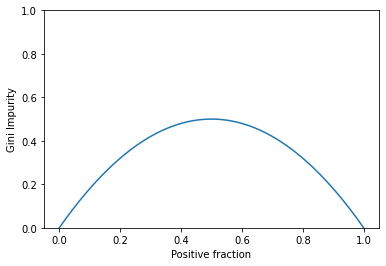

In [1]:
import matplotlib.pyplot as plt
import numpy as np

pos_fraction = np.linspace(0.00, 1.00, 1000)

gini = 1 - pos_fraction**2 - (1-pos_fraction)**2
plt.plot(pos_fraction, gini)
plt.ylim(0, 1)
plt.xlabel('Positive fraction')
plt.ylabel('Gini Impurity')
plt.show()

In [2]:
def gini_impurity(labels):
 # When the set is empty, it is also pure
 if not labels:
   return 0
 # Count the occurrences of each label
 counts = np.unique(labels, return_counts=True)[1]
 fractions = counts / float(len(labels))
 return 1 - np.sum(fractions ** 2)

In [3]:
print('{0:.4f}'.format(gini_impurity([1, 1, 0, 1, 0])))

0.4800


In [4]:
print('{0:.4f}'.format(gini_impurity([1, 1, 0, 1, 0, 0])))

0.5000


In [5]:
print('{0:.4f}'.format(gini_impurity([0, 0, 0, 0])))

0.0000


In [7]:
pos_fraction = np.linspace(0.00, 1.00, 1000)
ent = - (pos_fraction * np.log2(pos_fraction) + (1 - pos_fraction) * np.log2(1 - pos_fraction))

plt.plot(pos_fraction, ent)
plt.xlabel('Positive fraction')
plt.ylabel('Entropy')
plt.ylim(0, 1)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log2
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


In [8]:
def entropy(labels):
 if not labels:
   return 0
 counts = np.unique(labels, return_counts=True)[1]
 fractions = counts / float(len(labels))
 return - np.sum(fractions * np.log2(fractions))

In [9]:
print('{0:.4f}'.format(entropy([1, 1, 0, 1, 0])))

0.9710


In [10]:
print('{0:.4f}'.format(entropy([1, 1, 0, 1, 0, 0])))

1.0000


In [11]:
print('{0:.4f}'.format(entropy([1, 1, 1, 1,1])))

-0.0000


In [12]:
criterion_function = {'gini': gini_impurity, 'entropy': entropy}

def weighted_impurity(groups, criterion='gini'):
 """ Calculate weighted impurity of children after a split
 Args:
  groups (list of children, and a child consists a list of class labels)
  criterion (metric to measure the quality of a split, 'gini' for Gini Impurity or 'entropy' for Information Gain)
 Returns:
  float, weighted impurity
 """
 total = sum(len(group) for group in groups)
 weighted_sum = 0.0
 for group in groups:
  weighted_sum += len(group) / float(total) * criterion_function[criterion](group)
 return weighted_sum

In [13]:
children_1 = [[1, 0, 1], [0, 1]]
children_2 = [[1, 1], [0, 0, 1]]

In [14]:
print('Entropy of #1 split: {0:.4f}'.format(weighted_impurity(children_1, 'entropy')))

Entropy of #1 split: 0.9510


In [15]:
print('Entropy of #2 split: {0:.4f}'.format(weighted_impurity(children_2, 'entropy')))

Entropy of #2 split: 0.5510


In [16]:
print('Gini of #1 split: {0:.4f}'.format(weighted_impurity(children_1, 'gini')))

Gini of #1 split: 0.4667


In [17]:
print('Gini of #2 split: {0:.4f}'.format(weighted_impurity(children_2, 'gini')))

Gini of #2 split: 0.2667


In [31]:
import pandas as pd

data = pd.read_csv('ctr_data_20000.csv')
data.columns

Index(['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21'],
      dtype='object')

In [32]:
data = data.drop(['id', 'hour', 'device_id', 'device_ip'], axis = 1)

In [33]:
from sklearn.feature_extraction import DictVectorizer

data_X = data.loc[ :, data.columns != 'click'].astype('str')
data_y = data.loc[ :, data.columns == 'click'].astype('int').values.ravel()

train_X, test_X = data_X[0:15000], data_X[15000:]
train_y, test_y = data_y[0:15000], data_y[15000:]

dict_one_hot_encoder = DictVectorizer(sparse=False)
onehot_train_X = dict_one_hot_encoder.fit_transform(train_X.to_dict('records'))
onehot_test_X = dict_one_hot_encoder.transform(test_X.to_dict('records'))

print(train_X.shape)
print(onehot_train_X.shape)

(15000, 19)
(15000, 3244)


In [34]:
from sklearn.tree import DecisionTreeClassifier
parameters = {'max_depth': [3, 10, None]}
decision_tree = DecisionTreeClassifier(criterion='gini', min_samples_split=30)

from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(decision_tree, parameters, n_jobs=-1, cv=3, scoring='roc_auc')
grid_search.fit(onehot_train_X, train_y)
print(grid_search.best_params_)

{'max_depth': 10}


In [35]:
decision_tree_best = grid_search.best_estimator_
pos_prob = decision_tree_best.predict_proba(onehot_test_X)[:, 1]

from sklearn.metrics import roc_auc_score
print('The ROC AUC on testing set is: {0:.3f}'.format(roc_auc_score(test_y, pos_prob)))

The ROC AUC on testing set is: 0.688


In [36]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_split=30, n_jobs=-1)

grid_search = GridSearchCV(random_forest, parameters, n_jobs=-1, cv=3, scoring='roc_auc')
grid_search.fit(onehot_train_X, train_y)
print(grid_search.best_params_)

{'max_depth': None}


In [37]:
random_forest_best = grid_search.best_estimator_
pos_prob = random_forest_best.predict_proba(onehot_test_X)[:, 1]

from sklearn.metrics import roc_auc_score
print('The ROC AUC on testing set is: {0:.3f}'.format(roc_auc_score(test_y, pos_prob)))

The ROC AUC on testing set is: 0.706


In [38]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

decision_tree = DecisionTreeClassifier(criterion='gini', min_samples_split=30, max_depth=3)

clf = AdaBoostClassifier(base_estimator = decision_tree, n_estimators=50, learning_rate=1)
clf.fit(onehot_train_X, train_y)

pos_prob = clf.predict_proba(onehot_test_X)[:, 1]
print('The ROC AUC on testing set is: {0:.3f}'.format(roc_auc_score(test_y, pos_prob)))

The ROC AUC on testing set is: 0.705
